In [1]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import splitfolders
import PIL
import os
import sys
import albumentations as A
import cv2
import pandas as pd
import numpy as np
import random
from pathlib import Path
from PIL import UnidentifiedImageError
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/IS4242 Group 1

Mounted at /content/drive
/content/drive/MyDrive/IS4242 Group 1


### Read Images Ten Classes

In [6]:
# Checks for corrupted images in these folders and removes them
paths = []
paths.append(Path("./training_images_ten/Capsicum_Green").rglob("*jpg"))
paths.append(Path("./training_images_ten/Capsicum_Red").rglob("*jpg"))
paths.append(Path("./training_images_ten/Capsicum_Yellow").rglob("*jpg"))
paths.append(Path("./training_images_ten/Tomato").rglob("*jpg"))
paths.append(Path("./training_images_ten/Apple_Red").rglob("*jpg"))
paths.append(Path("./training_images_ten/Apple_Green").rglob("*jpg"))
paths.append(Path("./training_images_ten/Banana").rglob("*jpg"))
paths.append(Path("./training_images_ten/Orange").rglob("*jpg"))
paths.append(Path("./training_images_ten/Pear").rglob("*jpg"))
paths.append(Path("./training_images_ten/Lemon").rglob("*jpg"))
for path in paths:
  for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)
            !rm $img_p

In [7]:
input_folder = "./training_images_ten"
output_folder = "./codes/data/ten_classes"
# For train/val split use 0.75,0.25
# For train/val/test split use 0.8,0.1,0.1
splitfolders.ratio(input_folder, output_folder, seed=4242, ratio=(0.75,0.25), group_prefix=None, move=False)

Copying files: 200 files [01:09,  2.88 files/s]


### Read Images Seven Classes

In [8]:
# Checks for corrupted images in these folders and removes them
paths = []
paths.append(Path("./training_images_seven/Capsicum").rglob("*jpg"))
paths.append(Path("./training_images_seven/Tomato").rglob("*jpg"))
paths.append(Path("./training_images_seven/Apple").rglob("*jpg"))
paths.append(Path("./training_images_seven/Banana").rglob("*jpg"))
paths.append(Path("./training_images_seven/Orange").rglob("*jpg"))
paths.append(Path("./training_images_seven/Pear").rglob("*jpg"))
paths.append(Path("./training_images_seven/Lemon").rglob("*jpg"))
for path in paths:
  for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)
            !rm $img_p

In [9]:
input_folder = "./training_images_seven"
output_folder = "./codes/data/seven_classes"
# For train/val split use 0.75,0.25
# For train/val/test split use 0.8,0.1,0.1
splitfolders.ratio(input_folder, output_folder, seed=4242, ratio=(0.75,0.25), group_prefix=None, move=False)

Copying files: 140 files [01:11,  1.96 files/s]


### Image Augmentation

In [10]:
#Read the image files
#Set os to the directory containing all the images with the folder name being the label
def read_images(dir_list):
  os.chdir(dir_list)
  dir_list = os.listdir(dir_list)
  df = pd.DataFrame({'Image': [], 'Label': []})
  for folder in dir_list:
    for file in os.listdir(folder):
        image = cv2.imread(folder + "/" + file)
        #print(folder + "/" + file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        new_row = {'Image': image, 'Label': folder}
        df.loc[len(df)] = new_row
  return df

In [11]:
#Image Augmentation
#Can use keras.ImageDataGenerator also
def transform_image(image):
    #Function to augment image
    transform = A.Compose([
        #Each transformation has probability = 0.5 of occurring by default
        A.LongestMaxSize(max_size = 512, interpolation = 3),
        A.HorizontalFlip(p=0.3),
        A.VerticalFlip(p=0.3),
        A.ISONoise(p=0.5),
        A.AdvancedBlur(p=0.3),
        A.RandomBrightnessContrast(p=0.3),
    ])
    augmented_image = transform(image=image)['image']
    return augmented_image

#First, augment the training data
def augment_data(X, n):
    df_temp = pd.DataFrame({'Image': [], 'Label': ""})
    X = X.reset_index()
    X = X.drop(labels = 'index', axis = 1)
    le = LabelEncoder()
    le.fit(X['Label'])
    labels = le.transform(X['Label'])
    classes = list(le.classes_)
    for label in classes:
        #Randomly selects image sequence to augment
        indexes = X[X['Label'] == label].index
        sequence = random.choices(indexes, k = n)
        for i in range(len(sequence)):
            #Augments image and adds to the new training dataframe
            index = sequence[i]
            image = X.iloc[index]['Image']
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            augmented_image = transform_image(image)
            new_row = {'Image': augmented_image, 'Label': label}
            df_temp.loc[len(df_temp)] = new_row
    X = df_temp.drop('Label', axis = 1)
    y = []
    for i in range(len(classes)):
        temp = [i] * n
        y += temp
    return X, y, le

#Save the augmented images
def save_images(X_train_aug, y_train_aug, le, save_dir):
  for i in range(X_train_aug.shape[0]):
    image = X_train_aug.iloc[i]['Image']
    labels = le.inverse_transform(y_train_aug)
    label = labels[i]
    os.chdir(save_dir + label + "/")
    filename = str(i % 100) + ".jpg"
    #print(filename)
    cv2.imwrite(filename, image)

### Ten Classes

In [12]:
#Set random seed for repeatable results
random.seed(4242)

df_ten = read_images("/content/drive/MyDrive/IS4242 Group 1/codes/data/ten_classes/train")
X_train_aug_ten, y_train_aug_ten, le_ten = augment_data(df_ten, 100)
save_images(X_train_aug_ten, y_train_aug_ten, le_ten, "/content/drive/MyDrive/IS4242 Group 1/codes/data/ten_classes/augmented/")

/usr/local/lib/python3.9/dist-packages/pandas/core/dtypes/cast.py:948: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


### Seven Classes

In [13]:
df_seven = read_images("/content/drive/MyDrive/IS4242 Group 1/codes/data/seven_classes/train")
X_train_aug_seven, y_train_aug_seven, le_seven = augment_data(df_seven, 100)
save_images(X_train_aug_seven, y_train_aug_seven, le_seven, "/content/drive/MyDrive/IS4242 Group 1/codes/data/seven_classes/augmented/")

/usr/local/lib/python3.9/dist-packages/pandas/core/dtypes/cast.py:948: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


In [18]:
# Analysis of final datasets
# Plot image dimensions

def read_images2():
    #Reads images from the current directory after data preprocessing
    #Change directory to the seven_classes/ten_classes folder
    os.chdir("/content/drive/MyDrive/IS4242 Group 1/codes/data/seven_classes/augmented/")
    dir_list = os.listdir("/content/drive/MyDrive/IS4242 Group 1/codes/data/seven_classes/augmented/")
    aug_df = pd.DataFrame({'Image': [], 'Label': []})
    for folder in dir_list:
        for file in os.listdir(folder):
            image = cv2.imread(folder + "/" + file)
            print(folder + "/" + file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            new_row = {'Image': image, 'Label': folder}
            aug_df.loc[len(aug_df)] = new_row
    os.chdir("/content/drive/MyDrive/IS4242 Group 1/codes/data/seven_classes/augmented/")
    dir_list = os.listdir("/content/drive/MyDrive/IS4242 Group 1/codes/data/seven_classes/augmented/")
    c_df = pd.DataFrame({'Image': [], 'Label': []})
    for folder in dir_list:
        for file in os.listdir(folder):
            image = cv2.imread(folder + "/" + file)
            print(folder + "/" + file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            new_row = {'Image': image, 'Label': folder}
            c_df.loc[len(c_df)] = new_row   
    return aug_df, c_df


In [ ]:
#Seven classes
#os.chdir("../seven_classes")
aug7_df, c7_df = read_images2()

#Plot the dimensions
def to_height_width(df):
    h = []
    w = []
    l = []
    for i in range(df.shape[0]):
        h.append(df.iloc[i]['Image'].shape[0])
        w.append(df.iloc[i]['Image'].shape[1])
        l.append(df.iloc[i]['Label'])
    df = pd.DataFrame({"Height": h,
                      "Width": w,
                      "Label": l})
    return df

aug7_df = to_height_width(aug7_df)
c7_df = to_height_width(c7_df)

[Text(0.5, 1.0, 'Image Dimensions for Augmented Dataset (7 Classes)')]

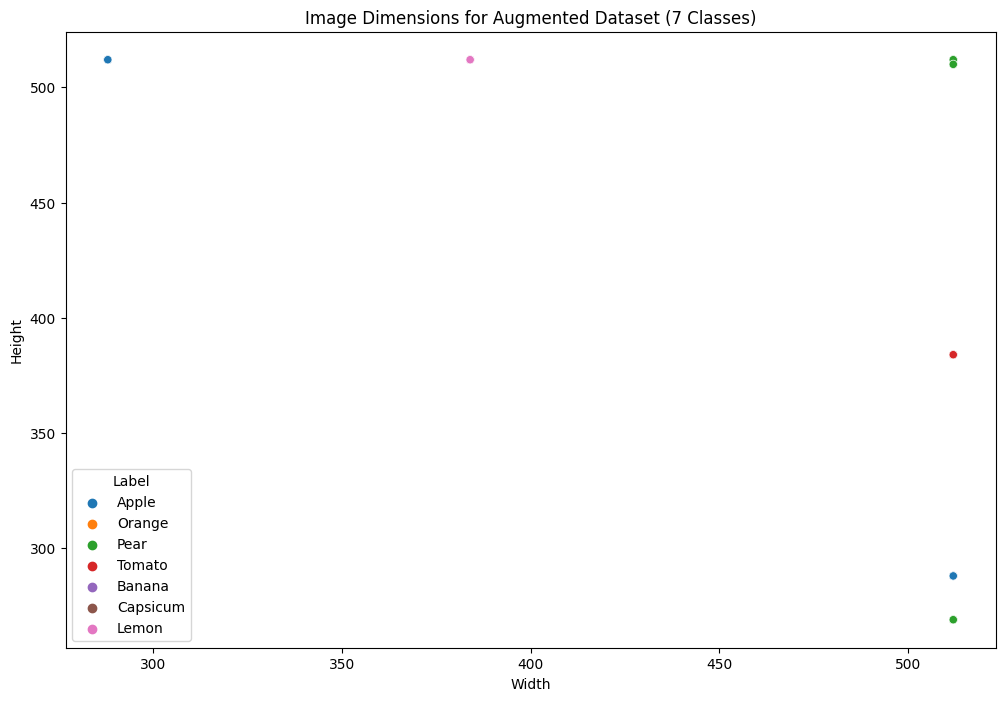

In [20]:
plt.figure(figsize=(12,8))
sns.scatterplot(data = aug7_df, x = "Width", y = "Height", hue = "Label").set(title = 'Image Dimensions for Augmented Dataset (7 Classes)')

[Text(0.5, 1.0, 'Image Dimensions for Control Dataset (10 Classes)')]

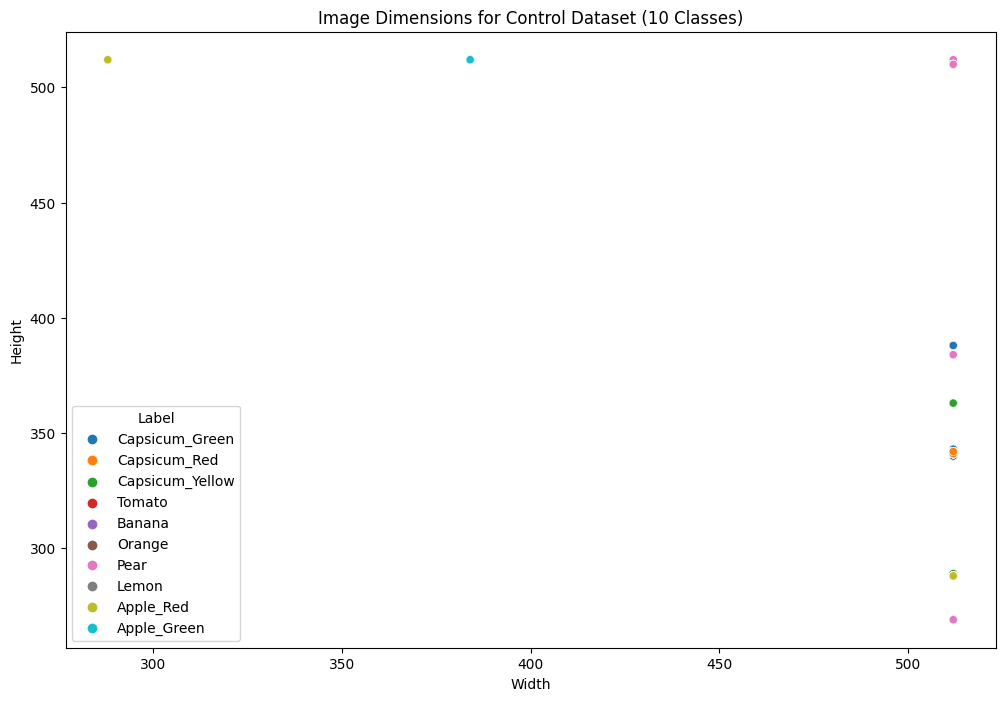

In [23]:
plt.figure(figsize=(12,8))
sns.scatterplot(data = c7_df, x = "Width", y = "Height", hue = "Label").set(title = 'Image Dimensions for Control Dataset (10 Classes)')